<a href="https://colab.research.google.com/github/eliransr/deepLearning_models/blob/master/Bears%20classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Creating my own dataset from Google Images**

In [2]:
###Create directory and upload urls files into my server
from fastai import *
from fastai.vision import *

## **Get a list of URLs**

In [ ]:
##Go to Google Images and search for the images you are interested in.
##Download into file
# urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
# window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

In [6]:
##Create directory and upload urls file into your server
#Choose an appropriate name for your labeled images. You can run these steps multiple times to create different labels.
folder = 'black'
file = 'black_bears.txt'

In [37]:
folder = 'grizzly'
file = 'brown_bears.txt'

In [40]:
folder = 'teddys'
file = 'teddys.txt'

In [4]:
#You will need to run this cell once per each category.
path = Path('data/bears')
dest = path/folder
dest.mkdir(parents=True , exist_ok=True)

## **Download images**

In [8]:
#download they images from their respective urls.
classes = ['teddys' , 'grizzly' , 'black']

In [ ]:
#You will need to run this cell once per each category.
download_images(path/file,dest, max_pics=200)
# If you have problems download, try with `max_workers=0` to see exceptions:
# download_images(path/file, dest, max_pics=20, max_workers=0)

In [63]:
#For remove any images that can't be opened
for c in classes:
  print(c)
  verify_images(path/c, delete=True, max_workers=8)

teddys


grizzly


black


## **View data**

In [66]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
       ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [67]:
data.classes

['black', 'grizzly', 'teddys']

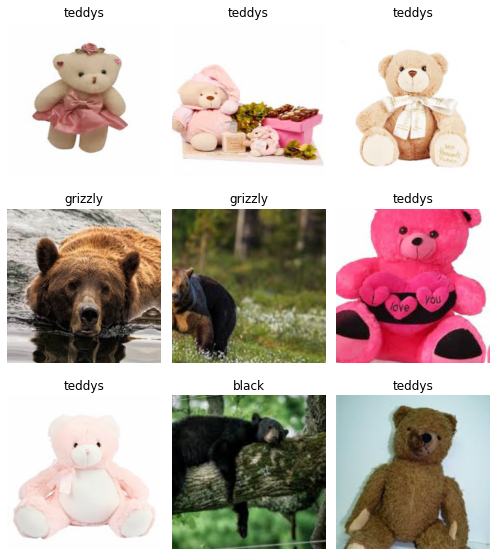

In [68]:
#Let's take a look at some of our pictures then.
data.show_batch(rows=3, figsize=(7,8))

In [69]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['black', 'grizzly', 'teddys'], 3, 173, 43)

## **Train model**

In [70]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [71]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.927136,1.146486,0.302326,00:46
1,1.347873,0.204168,0.093023,00:42
2,0.951817,0.084337,0.046512,00:41
3,0.787673,0.061015,0.023256,00:41


In [50]:
learn.save('stage-1')

In [51]:
learn.unfreeze()

In [52]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


In [ ]:

# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(2, max_lr=slice(3e-5,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.249754,0.049724,0.023256,01:03
1,0.144412,0.078903,0.023256,01:04


In [55]:
learn.save('stage-2')

## **Interpretation**

In [56]:
learn.load('stage-2');

In [57]:
interp = ClassificationInterpretation.from_learner(learn)

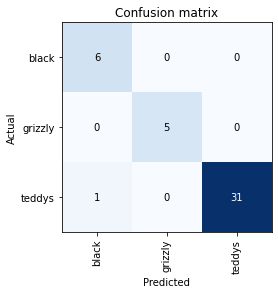

In [58]:
interp.plot_confusion_matrix()

## **Cleaning Up**

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the ImageCleaner widget from fastai.widgets we can prune our top losses, removing photos that don't belong.

In [ ]:
from fastai.widgets import *

First we need to get the file paths from our top_losses. We can do this with .from_toplosses. We then feed the top losses indexes and corresponding dataset to ImageCleaner.


In order to clean the entire set of images, we need to create a new dataset without the split. The video lecture demostrated the use of the ds_type param which no longer has any effect.

In [ ]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

In [ ]:
# If you already cleaned your data using indexes from `from_toplosses`,
# run this cell instead of the one before to proceed with removing duplicates.
# Otherwise all the results of the previous step would be overwritten by
# the new run of `ImageCleaner`.

# db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
#                    .split_none()
#                    .label_from_df()
#                    .transform(get_transforms(), size=224)
#                    .databunch()
#      )


Then we create a new learner to use our new databunch with all the images.

In [ ]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

learn_cln.load('stage-2');


In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via /tree, not /lab. Running the ImageCleaner widget in Jupyter Lab is not currently supported.

In [ ]:
# Don't run this in google colab or any other instances running jupyter lab.
# If you do run this on Jupyter Lab, you need to restart your runtime and
# runtime state including all local variables will be lost.
ImageCleaner(ds, idxs, path)

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. ImageCleaner will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from top_losses.ImageCleaner(ds, idxs)

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

Remember to recreate your ImageDataBunch from your cleaned.csv to include the changes you made in your data!